# Übung 8: Generative adversarial networks

Generative adversarial networks (GANs) lernen implizit ein generatives Modell von einer gegebenen Datendistribution. Dies geschieht durch ein Nullsummenspiel zwischen zwei neuronalen Netzwerken: Ein Generatornetzwerk versucht eine Funktion zu lernen, die Zufallsdaten aus einer einfachen parametrischen Verteilung in Bilder überführt, die von dem zweiten Netzwerk, dem Diskriminator, nicht von echten Bildern zu unterscheiden sind. Der Diskriminator ist ein Classifier, der darauf trainiert wird, echte Bilder von solchen zu unterscheiden, die der Generator generiert.

In dieser Übung sollst du ein GAN für den MNIST Datensatz implementieren.

## MNIST

Laden den MNIST Datensatz und plotte ein paar der Datenpunkte als Bilder. Du kannst das Keras modul ```keras.datasets``` benutzen, um die Daten automatisch herunterzuladen und einzulesen.

60000 train samples
10000 test samples


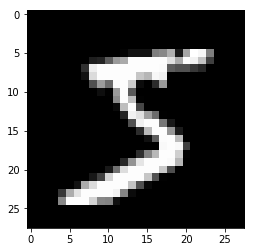

In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()

plt.imshow(X_train[0], cmap=plt.cm.gray)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


## Generator

Erstelle nun zuerst ein Model, welches aus einem Tensor mit den Dimensionen ```[batch_size, z_dim]``` einen Tensor mit den Dimensionen ```[batch_size, 28, 28, 1]``` generiert. ```28x28``` ist hierbei die Bildgröße der MNIST Daten, die Größe des Noisevektors (```z_dim```) kannst du selbst wählen. 

Sample nun eine Batch von Zufallswerten, z.b. aus einer Normalverteilung, und erstelle mit dem untrainierten Generator ein Batch von Bildern. Plotte diese generierten Bilder.

In [3]:
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def plot_imgs(generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

In [5]:
z_dim = 32
batch_size = 64
img_rows = 28
img_cols = 28
channels = 1


X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
noise_shape = (z_dim,)
        
model = Sequential()

model.add(Dense(512 * 14 * 14, activation="relu", input_shape=noise_shape))
model.add(Reshape((14, 14, 512)))
model.add(BatchNormalization(momentum=0.8))
model.add(UpSampling2D())

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='glorot_uniform')) #Xavier uniform initializer
model.add(BatchNormalization(momentum=0.8))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='glorot_uniform')) #Xavier uniform initializer
model.add(BatchNormalization(momentum=0.8))
#model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='glorot_uniform')) #Xavier uniform initializer
model.add(BatchNormalization(momentum=0.8))
model.add(Activation('relu'))


model.add(Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')) #Xavier uniform initializer
model.add(Activation("tanh"))

model.summary()

noise = Input(shape=noise_shape)
img = model(noise)

generator = Model(noise, img)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100352)            3311616   
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 512)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 512)       2048      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       589952    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 128)       0         
__________

In [7]:
noise = np.random.normal(0, 1, (batch_size, z_dim))

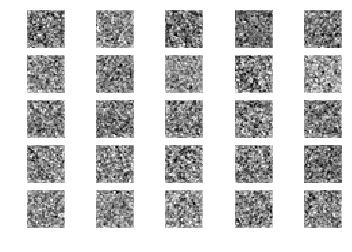

In [8]:
plot_imgs(generator)

## Discriminator

Erstelle nun ein Klassifizierungsnetzwerk, welchen mit dem Ausgabetensor des Generatornetzes (```[batch_size, 28, 28, 1]```) als Eingabe akzeptiert. Überprüfe, ob das Netzwerk die Ausgaben des Generators in Wahrscheinlichkeiten, also Werte zwischen 0 und 1, überführt.

In [11]:

img_shape = (img_rows, img_cols, channels)
        
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=3, strides=1, input_shape=img_shape, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()

img = Input(shape=img_shape)
validity = model(img)

discriminator = Model(img, validity)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)         73856     
__________

In [12]:
discriminator.predict(generator.predict(noise))

array([[0.50029045],
       [0.50017095],
       [0.5002265 ],
       [0.50018877],
       [0.50011665],
       [0.50001174],
       [0.50011486],
       [0.5004145 ],
       [0.50028485],
       [0.5003109 ],
       [0.50012076],
       [0.50059223],
       [0.50001925],
       [0.49988523],
       [0.50011533],
       [0.5002061 ],
       [0.5000909 ],
       [0.5002588 ],
       [0.5005227 ],
       [0.50019634],
       [0.5001034 ],
       [0.50024796],
       [0.5005811 ],
       [0.50021636],
       [0.5003228 ],
       [0.49990347],
       [0.50014096],
       [0.50055176],
       [0.5001742 ],
       [0.5004114 ],
       [0.49983364],
       [0.50013644],
       [0.5005237 ],
       [0.5005409 ],
       [0.50016063],
       [0.4999218 ],
       [0.50010306],
       [0.50013506],
       [0.5003377 ],
       [0.50008786],
       [0.50043225],
       [0.50014347],
       [0.50036246],
       [0.50016487],
       [0.50008255],
       [0.5001978 ],
       [0.50022584],
       [0.499

## Training
Implementiere das Training des GANs wie in der Vorlesung besprochen. Gebe während des Trainings den Generator-Loss und den Discriminator-Loss aus. Am Ende des Trainings zeige einige vom Generator generierte Bilder (**RESULT**).